In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import os

(4160, 3120)
size template: width:  377 height:  158
nilai max (867, 1472)
nilai min: (717, 1379)
nilai max val: 50688112.0
nilai min val: -48741008.0
(1244, 1630)


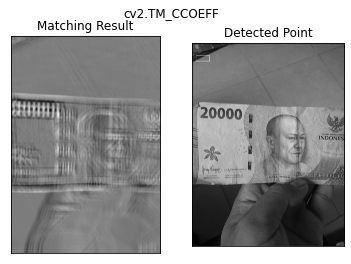

nilai max (424, 1089)
nilai min: (732, 2745)
nilai max val: 0.27318376302719116
nilai min val: -0.278698593378067
(801, 1247)


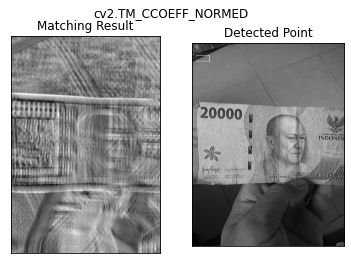

nilai max (176, 1681)
nilai min: (62, 4002)
nilai max val: 1093759488.0
nilai min val: 49248944.0
(553, 1839)


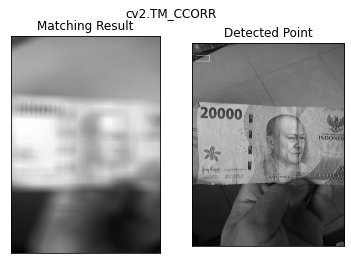

nilai max (192, 1077)
nilai min: (248, 4002)
nilai max val: 0.8544106483459473
nilai min val: 0.4442744255065918
(569, 1235)


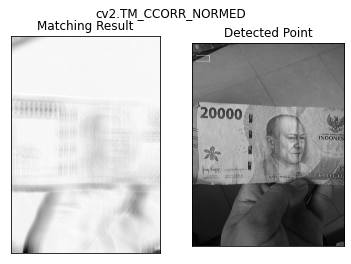

nilai max (1751, 1572)
nilai min: (604, 1096)
nilai max val: 728651840.0
nilai min val: 222885632.0
(981, 1254)


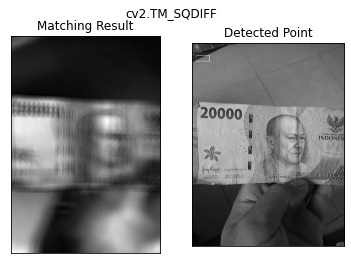

nilai max (198, 0)
nilai min: (192, 1077)
nilai max val: 1.0
nilai min val: 0.2917664647102356
(569, 1235)


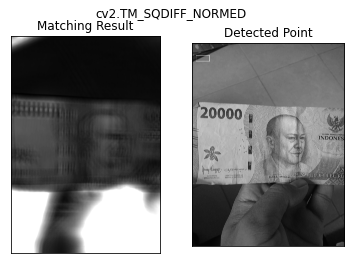

In [3]:
img = cv2.imread('tmp/image.jpg', cv2.IMREAD_GRAYSCALE)
print(img.shape)
assert img is not None, "file could not be read, check with os.path.exists()"
img2 = img.copy()
template = cv2.imread('template/1000/v2/nominal.jpg', cv2.IMREAD_GRAYSCALE)
assert template is not None, "file could not be read, check with os.path.exists()"
w, h = template.shape[::-1]
print('size template: width: ',w,'height: ',h)
# All the 6 methods for comparison in a list
methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
            'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']
for meth in methods:
    img = img2.copy()
    method = eval(meth)
    # Apply template Matching
    res = cv2.matchTemplate(img,template,method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    print('nilai max', max_loc)
    print('nilai min:', min_loc)
    print('nilai max val:', max_val)
    print('nilai min val:', min_val)
    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    print(bottom_right)
    cv2.rectangle(img,(83, 256), (360, 373), 255, 6)
    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img,cmap = 'gray')
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.suptitle(meth)
    plt.show()
    cv2.waitKey(10)
    cv2.destroyAllWindows()

In [4]:
def translate(image, x, y):
	# Define the translation matrix and perform the translation
	M = np.float32([[1, 0, x], [0, 1, y]])
	shifted = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))

	# Return the translated image
	return shifted

def rotate_bound(image, angle):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH))

def rotate(image, angle, center = None, scale = 1.0):
	# Grab the dimensions of the image
	(h, w) = image.shape[:2]

	# If the center is None, initialize it as the center of
	# the image
	if center is None:
		center = (w / 2, h / 2)

	# Perform the rotation
	M = cv2.getRotationMatrix2D(center, angle, scale)
	rotated = cv2.warpAffine(image, M, (w, h))

	# Return the rotated image
	return rotated

def resize(image, width = None, height = None, inter = cv2.INTER_AREA):
	# initialize the dimensions of the image to be resized and
	# grab the image size
	dim = None
	(h, w) = image.shape[:2]

	# if both the width and height are None, then return the
	# original image
	if width is None and height is None:
		return image

	# check to see if the width is None
	if width is None:
		# calculate the ratio of the height and construct the
		# dimensions
		r = height / float(h)
		dim = (int(w * r), height)

	# otherwise, the height is None
	else:
		# calculate the ratio of the width and construct the
		# dimensions
		r = width / float(w)
		dim = (width, int(h * r))

	# resize the image
	resized = cv2.resize(image, dim, interpolation = inter)

	# return the resized image
	return resized

In [5]:
def countResult(datas):
    sum_max_vals = {}
    count_max_vals = {}

    for data in datas:
        nominal = data['nominal']
        max_val = data['max_value']

        if nominal in sum_max_vals:
            sum_max_vals[nominal] += max_val
            count_max_vals[nominal] += 1
        else:
            sum_max_vals[nominal] = max_val
            count_max_vals[nominal] = 1

    average_max_vals = {}
    for nominal, total_max_val in sum_max_vals.items():
        average_max_vals[nominal] = sum_max_vals[nominal] / count_max_vals[nominal]
            
    return average_max_vals

def uang_matching():
    # load templatel
    template_datas = []
    template_files = glob.glob('template/*/*/*.jpg', recursive=True)
    print("template loaded:", template_files)
    # prepare template
    for template_file in template_files:
        tmp = cv2.imread(template_file)
        tmp = resize(tmp, width=int(tmp.shape[1]*0.5))  # scalling
        tmp = cv2.cvtColor(tmp, cv2.COLOR_BGR2GRAY)  # grayscale
        #split_path = template_file.replace('template\\', '').replace('v2\\', '')
        #nominal = split_path.split('\\')[0]
        
        normalized_path = os.path.normpath(template_file)
        directory, file_name = os.path.split(normalized_path)
        nominal, _ = os.path.split(directory)
        template_datas.append({"glob": tmp, "nominal": os.path.basename(nominal), "max_value": 0.0})
    
    
    # template matching
    for image_glob in glob.glob('tmp/*.jpg'):
        for template in template_datas:
            image_test = cv2.imread(image_glob)
            image_test = cv2.resize(image_test, (1200, 1600))
            (template_height, template_width) = template['glob'].shape[:2]
            cv2.imshow("Template", template['glob'])

            image_test_p = cv2.cvtColor(image_test, cv2.COLOR_BGR2GRAY)

            found = None
            thershold = 0.48
            for scale in np.linspace(0.2, 1.0, 20)[::-1]:
                # scalling uang
                resized = resize(
                    image_test_p, width=int(image_test_p.shape[1] * scale))
                r = image_test_p.shape[1] / float(resized.shape[1])
                cv2.imshow("Step: rescale", resized)
                if resized.shape[0] < template_height or resized.shape[1] < template_width:
                    break

                # template matching
                result = cv2.matchTemplate(resized, template['glob'], cv2.TM_CCOEFF_NORMED)
                (_, maxVal, _, maxLoc) = cv2.minMaxLoc(result)
                if found is None or maxVal > found[0]:
                    found = (maxVal, maxLoc, r)

            if found is not None:
                (maxVal, maxLoc, r) = found
                (startX, startY) = (int(maxLoc[0]*r), int(maxLoc[1] * r))
                (endX, endY) = (
                    int((maxLoc[0] + template_width) * r), int((maxLoc[1] + template_height) * r))
                print(maxVal)                    
                template['max_value'] = maxVal
                cv2.rectangle(image_test, (startX, startY),
                                (endX, endY), (0, 0, 255), 2)
                cv2.imshow("Result", image_test)

            cv2.waitKey(0)
    average_max_val = countResult(template_datas)
    max_nominal = max(average_max_val, key=average_max_val.get)
    max_average_max_val = average_max_val[max_nominal]
    sorted_average_max_vals = dict(sorted(average_max_val.items(), key=lambda item: item[1], reverse=True))

    print("average 'max_val' each nominal money: ", average_max_val)
    print("sorted from bigger value: ", sorted_average_max_vals)
    print(f"The 'nominal' with the maximum average 'max_val' is {max_nominal} with a value of {max_average_max_val}")


if __name__ == "__main__":
    uang_matching()
    
    cv2.waitKey(10)
    cv2.destroyAllWindows()

template loaded: ['template\\1000\\v2\\face.jpg', 'template\\1000\\v2\\nominal.jpg', 'template\\1000\\v3\\face.jpg', 'template\\1000\\v3\\nominal.jpg', 'template\\10000\\v2\\face.jpg', 'template\\10000\\v2\\nominal.jpg', 'template\\10000\\v3\\face.jpg', 'template\\10000\\v3\\nominal.jpg', 'template\\100000\\v2\\face.jpg', 'template\\100000\\v2\\template.jpg', 'template\\100000\\v3\\face.jpg', 'template\\100000\\v3\\nominal.jpg', 'template\\2000\\v2\\face.jpg', 'template\\2000\\v2\\nominal.jpg', 'template\\2000\\v3\\face.jpg', 'template\\2000\\v3\\nominal.jpg', 'template\\20000\\v2\\face.jpg', 'template\\20000\\v2\\nominal.jpg', 'template\\20000\\v3\\face.jpg', 'template\\20000\\v3\\nominal.jpg', 'template\\5000\\v2\\face.jpg', 'template\\5000\\v2\\nominal.jpg', 'template\\5000\\v3\\face.jpg', 'template\\5000\\v3\\nominal.jpg', 'template\\50000\\v2\\face.jpg', 'template\\50000\\v2\\nominal.jpg', 'template\\50000\\v3\\face.jpg', 'template\\50000\\v3\\nominal.jpg']
0.36305299401283264
0.7